In [1]:
import torch
from math import pi
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def data(batch_size, seq_length=128, fft_size=32, win_length=32, hop_length=32):
    y = ((torch.randn(batch_size, seq_length)+torch.arange(seq_length, dtype=torch.float))/(2*pi)).sin()
    x = torch.stft(y, n_fft=fft_size, win_length=win_length, hop_length=hop_length, return_complex=False)
    x_real = x[:, :, :, 0]
    return x_real, y

In [3]:
class FC(nn.Module):
    def __init__(self, out_len):
        super().__init__()
        self.fc = nn.Linear(out_len, out_len, bias=False)
        self.fc.weight.data = self.__invertible_weight(out_len)
    
    def __invertible_weight(self, out_len):
        W = torch.qr(torch.FloatTensor(out_len, out_len).normal_())[0]
        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1*W[:,0]
        return W.view(out_len, out_len)
        
    def forward(self, x):
        W = self.fc.weight.squeeze()
        W_inv = W.float().inverse()
        y = F.linear(x, W_inv, bias=None)
        return y
    
    def reverse(self, y):
        y = self.fc(y)
        batch_size = y.size(0)
        log_det_W = self.fc.weight.squeeze().logdet() * batch_size
        return y, log_det_W

class Phi(nn.Module):
    def __init__(self, seq_len, feature_len, hidden):
        super().__init__()
        half_seq_len = seq_len // 2
        self.feature_projection = nn.Sequential(
            nn.Linear(feature_len, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, half_seq_len)
        )
        self.log_s = nn.Sequential(
            nn.Linear(seq_len, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, half_seq_len)
        )
        self.b = nn.Sequential(
            nn.Linear(seq_len, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, half_seq_len)
        )
    
    def forward(self, xa, feature):
        zf = self.feature_projection(feature)
        za = torch.cat((xa, zf), dim=1)
        log_s, b = self.log_s(za), self.b(za)
        return log_s, b

class Flow(nn.Module):
    def __init__(self, seq_len, feature_len, hidden, flip):
        super().__init__()
        self.fc = FC(seq_len)
        self.phi = Phi(seq_len, feature_len, hidden)
        self.flip = flip
    
    def forward(self, z, feature):
        za, zb = z.chunk(2, dim=1)
        if self.flip:
            za, zb = zb, za
            
        log_s, b = self.phi(za, feature)
        ya = za
        yb = (zb - b) / log_s.exp()
        
        if self.flip:
            ya, yb = yb, ya
        y = self.fc(torch.cat((ya, yb), dim=1))
        return y
    
    def reverse(self, y, feature):
        y, log_det_W = self.fc.reverse(y)
        ya, yb = y.chunk(2, dim=1)
        if self.flip:
            ya, yb = yb, ya

        log_s, b = self.phi(ya, feature)
        za = ya
        zb = yb*log_s.exp() + b
        
        if self.flip:
            za, zb = zb, za
        z = torch.cat((za, zb), dim=1)
        return z, log_s, log_det_W

class Model(nn.Module):
    def __init__(self, seq_len, feature_len, hidden, num_flows):
        super().__init__()
        self.flows = nn.ModuleList([
            Flow(seq_len, feature_len, hidden, i%2==0)
            for i in range(num_flows)
        ])
        self.distribution = torch.distributions.MultivariateNormal(torch.zeros(seq_len), torch.eye(seq_len))
    
    def forward(self, batch_size, feature):
        y = self.distribution.rsample(sample_shape=(batch_size,))
        for flow in self.flows:
            y = flow(y, feature)
        return y
    
    def reverse(self, y, feature):
        """This is used for training in this system"""
        z = y
        log_jacob = 0
        log_det_w = 0
        for flow in reversed(self.flows):
            z, ls, lw = flow.reverse(z, feature)
            log_jacob += ls.sum(-1)
            log_det_w += lw
        log_pz = self.distribution.log_prob(z)
        return z, log_pz, log_jacob, log_det_w

/opt/conda/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


step 0000:: 161.99102783203125
step 0009:: -110.30120086669922
step 0018:: -321.5574645996094
step 0027:: -485.0812683105469
step 0036:: -640.1531982421875
step 0045:: -789.1478881835938
step 0054:: -937.7220458984375
step 0063:: -1082.7987060546875
step 0072:: -1224.75537109375
step 0081:: -1365.5177001953125
step 0090:: -1506.075439453125
step 0099:: -1646.88720703125



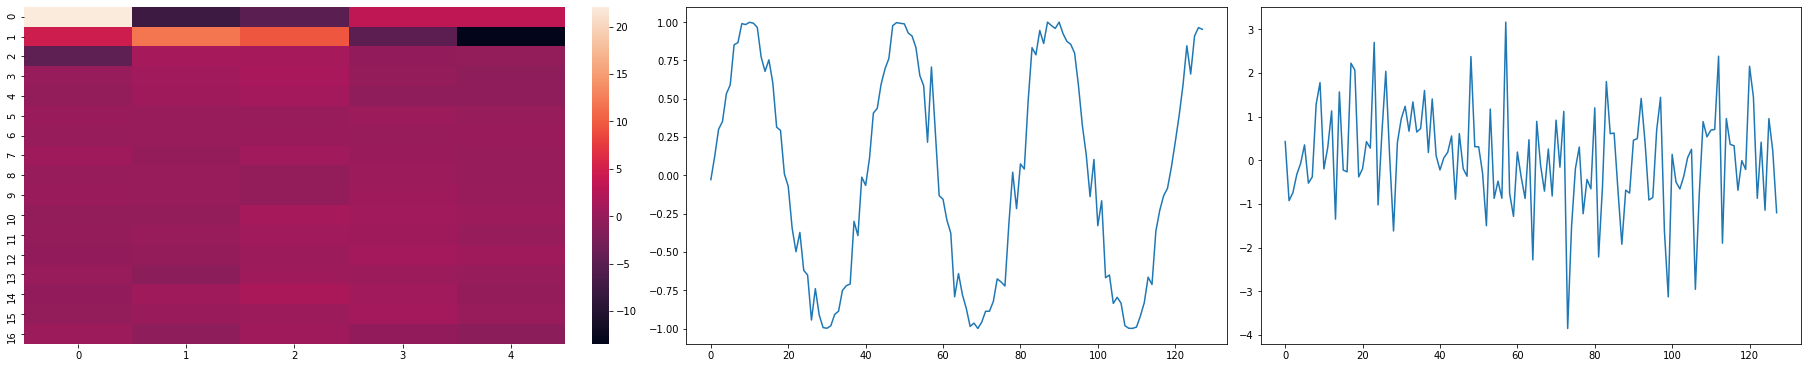

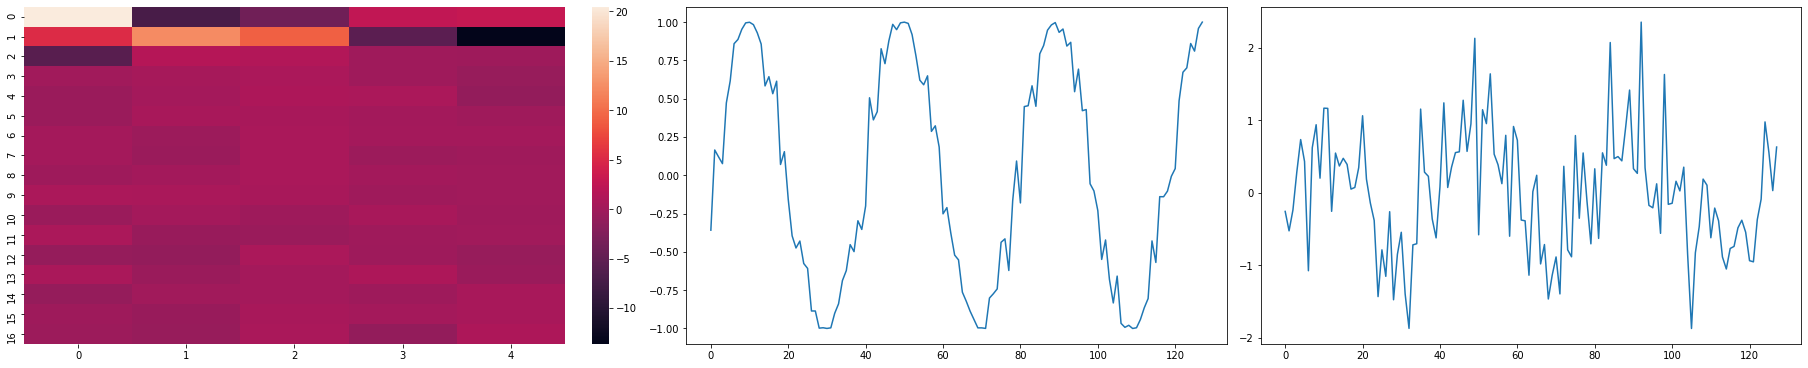

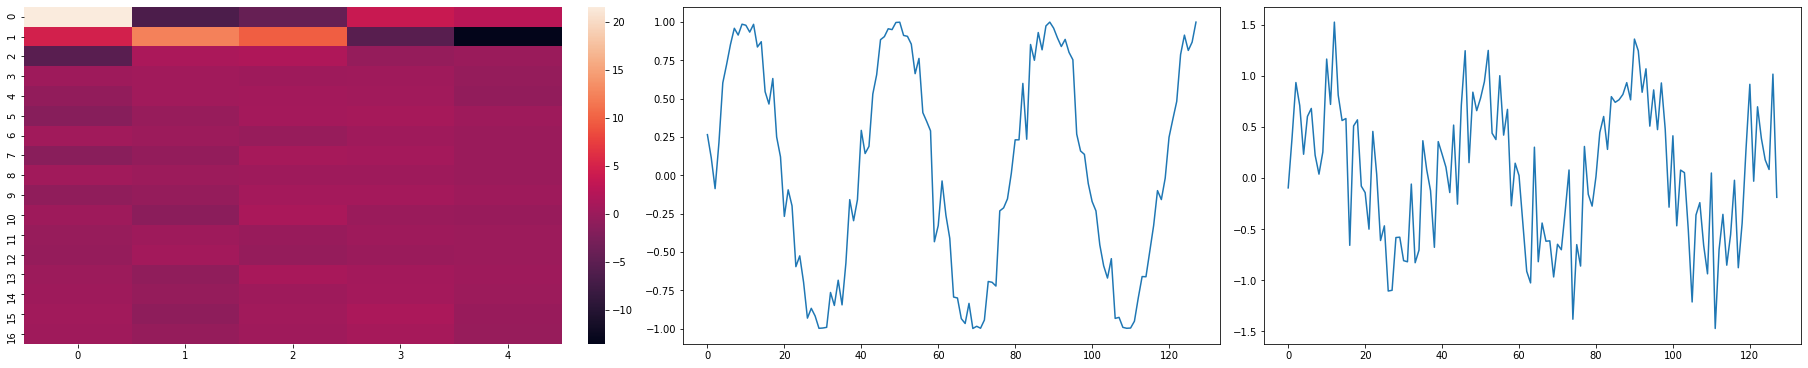

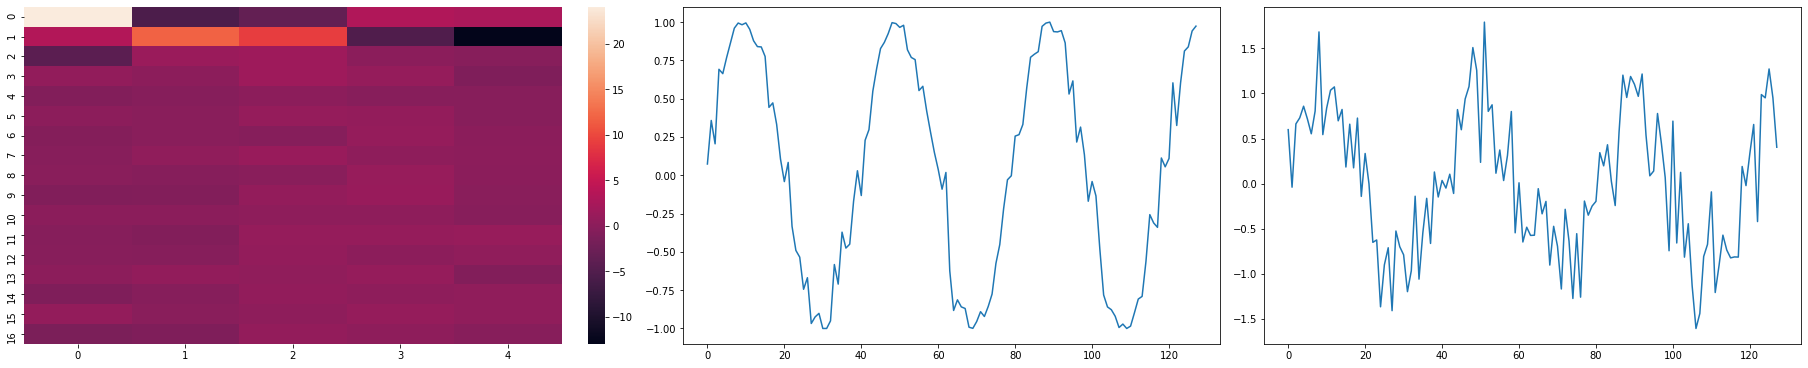

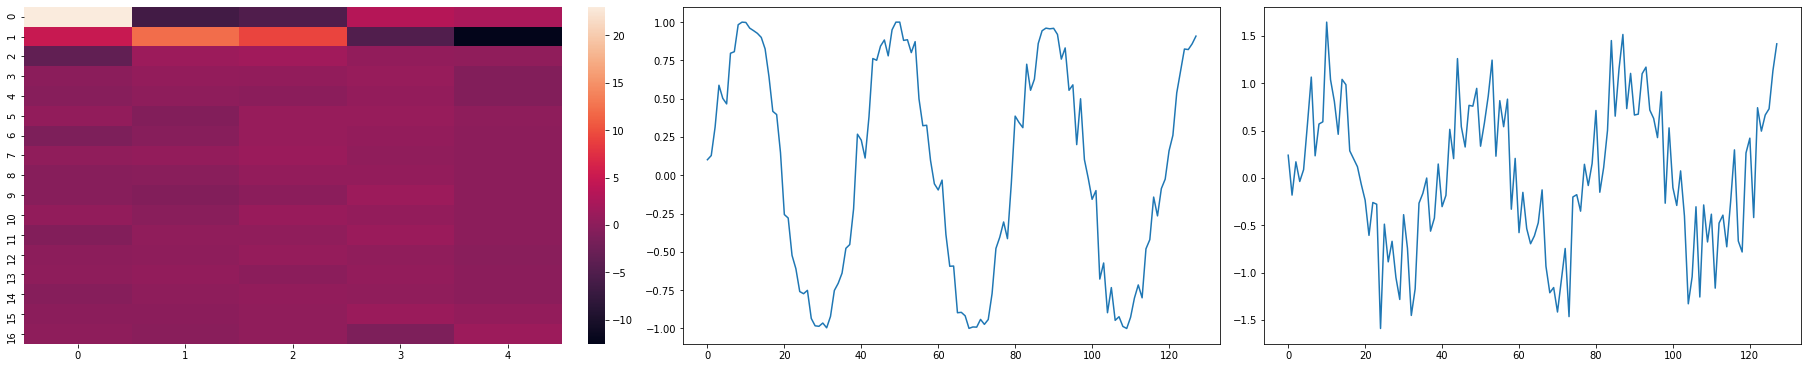

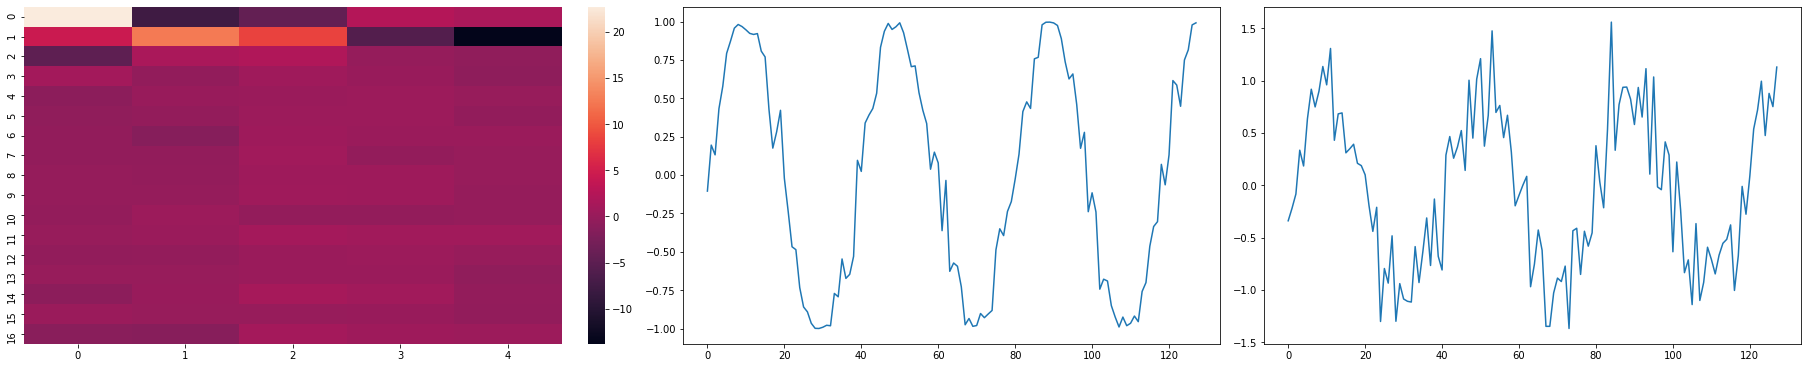

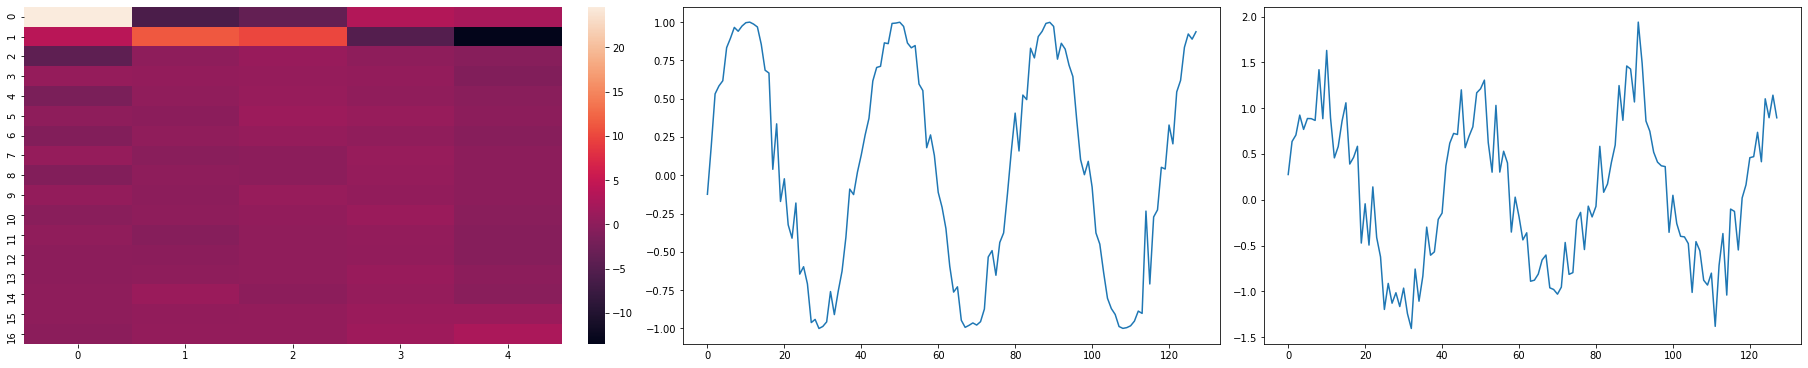

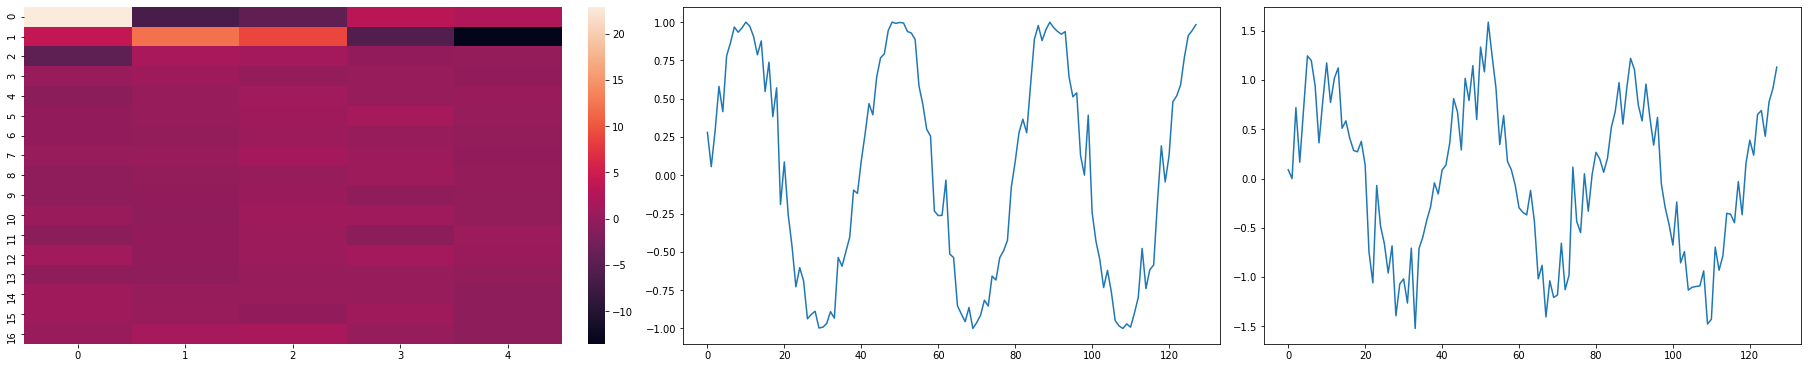

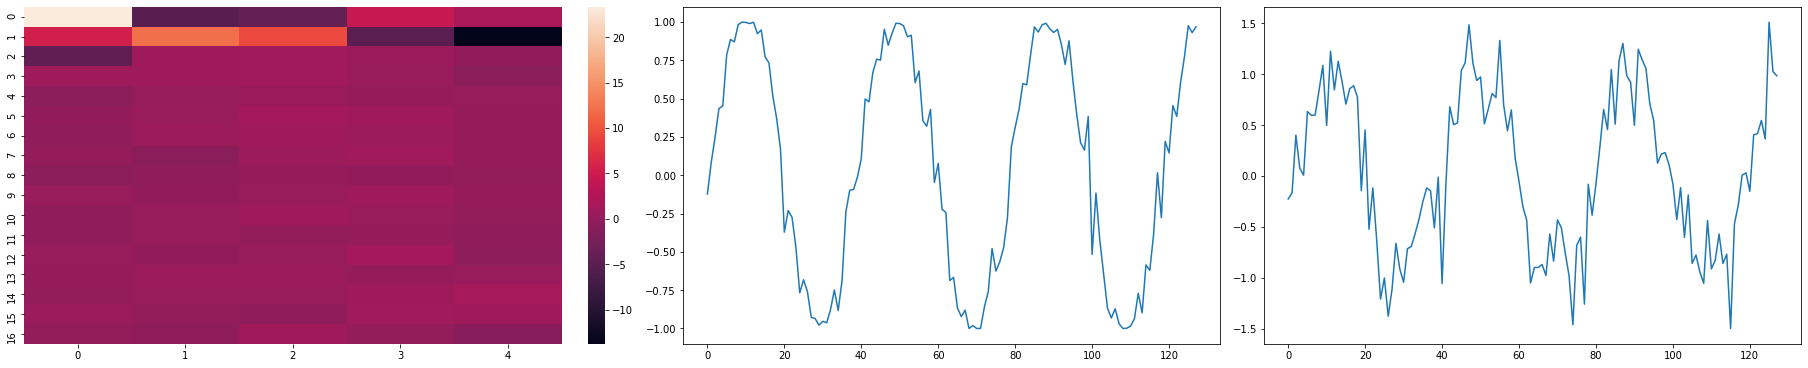

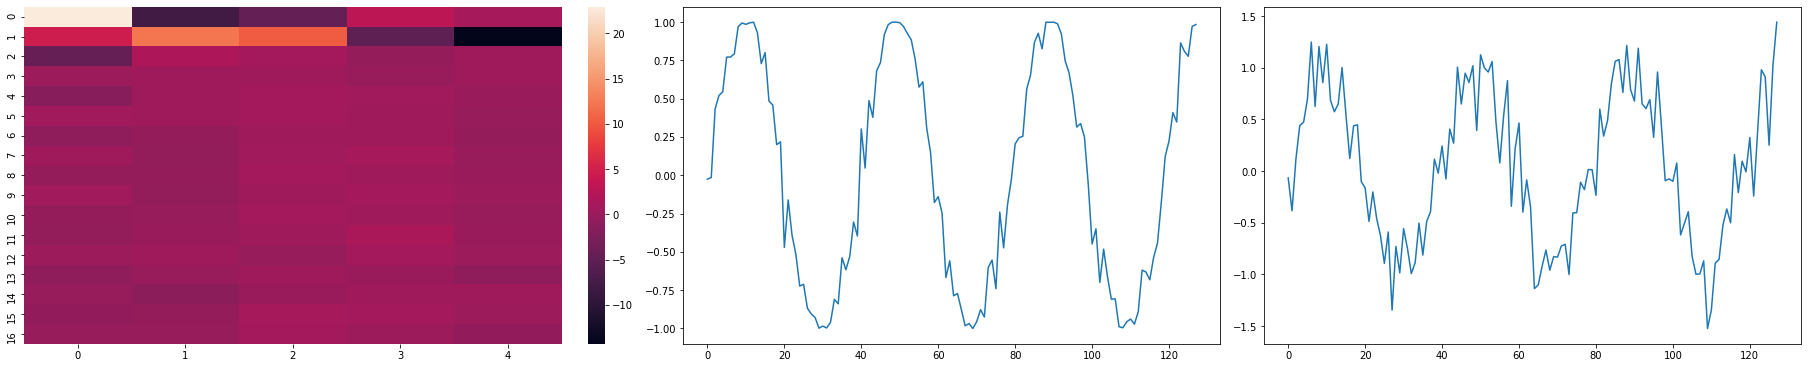

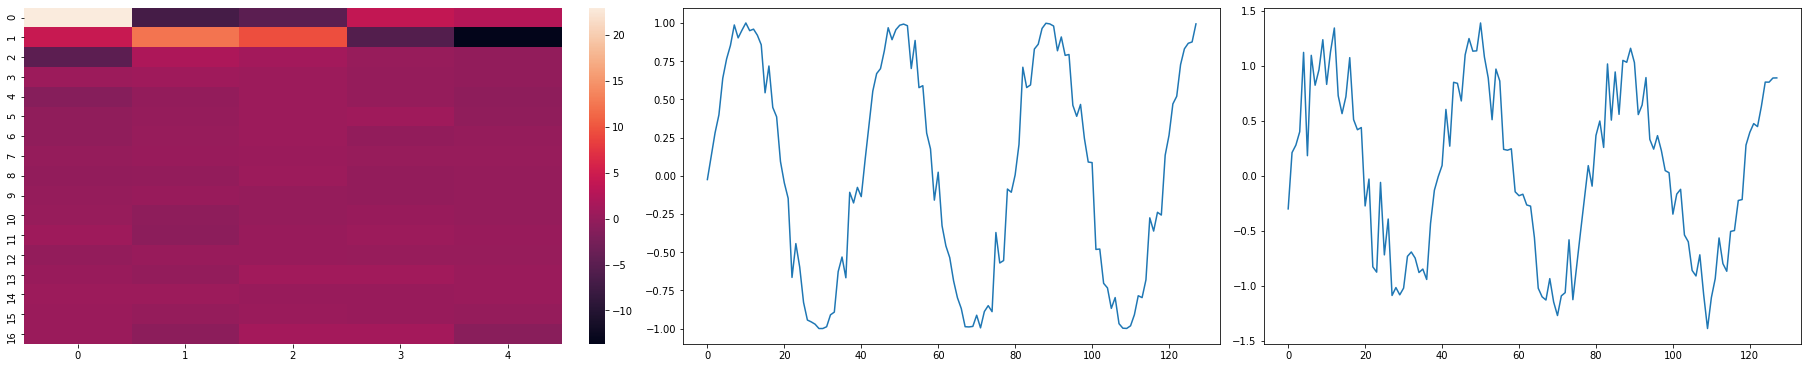

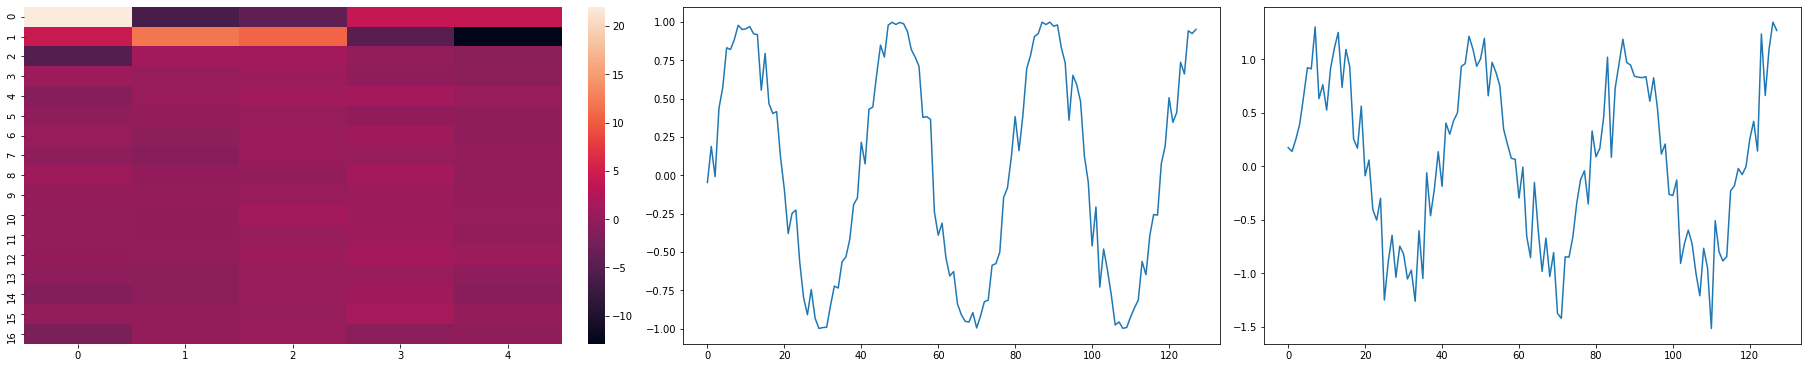

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq_length=128
fft_size=32
win_length=32
hop_length=32
num_flows = 5
batch_size = 32
epochs = 100
display_div = 9
feature_len =  (fft_size//2+1)*(seq_length//hop_length+1)

model = Model(seq_length, feature_len, 1024, num_flows)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)


for step in tqdm(range(epochs), "Fitting"):
    optim.zero_grad()
    x,y = data(batch_size, seq_length, fft_size, win_length, hop_length)
    z, log_pz, log_jacob, log_det_w = model.reverse(y, x.reshape(batch_size, -1))
    loss = (-log_pz - log_jacob - log_det_w).mean()
    loss.backward()
    optim.step()
    with torch.no_grad():
        if step % display_div == 0:
            print(f"step {step:04d}:: {loss.item()}")
            x,y = data(1, seq_length, fft_size, win_length, hop_length)
            y2 = model.forward(1, x.reshape(1, -1))
            fig, ax = plt.subplots(1,3, figsize=(25,5), constrained_layout=True)
            sns.heatmap(x[0], ax=ax[0])
            ax[1].plot(y[0])
            ax[2].plot(y2[0])
            fig.show()